In [2]:
import torch
torch.manual_seed(10)
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn import decomposition
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
import nltk
#Import stopwords
from nltk.corpus import stopwords

## data used

In [3]:
corpus = [
    'drink milk',
    'drink cold water',
    'drink cold cola',
    'drink juice',
    'drink cola',
    'eat bacon',
    'eat mango',
    'eat cherry',
    'eat apple',
    'juice with sugar',
    'cola with sugar',
    'mango is fruit',
    'apple is fruit',
    'cherry is fruit',
    'Berlin is Germany',
    'Boston is USA',
    'Mercedes from Germany',
    'Mercedes is a car',
    'Ford from USA',
    'Ford is a car'
]

In [4]:
def create_vocabulary(corpus):
    '''Creates a dictionary with all unique words in corpus with id'''
    vocabulary = {}
    i = 0
    for s in corpus:
        for w in s.split():
            if w not in vocabulary:
                vocabulary[w] = i
                i+=1
    return vocabulary

def prepare_set(corpus, n_gram = 1):
    '''Creates a dataset with Input column and Outputs columns for neighboring words. 
       The number of neighbors = n_gram*2'''
    columns = ['Input'] + [f'Output{i+1}' for i in range(n_gram*2)]
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i,w in enumerate(sentence.split()):
            inp = [w]
            out = []
            for n in range(1,n_gram+1):
                # look back
                if (i-n)>=0:
                    out.append(sentence.split()[i-n])
                else:
                    out.append('<padding>')
                    # look forward
                if (i+n)<len(sentence.split()):
                    out.append(sentence.split()[i+n])
                else:
                    out.append('<padding>')
            row = pd.DataFrame([inp+out], columns = columns)
            result = result.append(row, ignore_index = True)
    return result
def prepare_set_ravel(corpus, n_gram = 1):
    '''Creates a dataset with Input column and Output column for neighboring words. 
       The number of neighbors = n_gram*2'''
    columns = ['Input', 'Output']
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i,w in enumerate(sentence.split()):
            inp = w
            for n in range(1,n_gram+1):
                # look back
                if (i-n)>=0:
                    out = sentence.split()[i-n]
                    row = pd.DataFrame([[inp,out]], columns = columns)
                    result = result.append(row, ignore_index = True)
                    # look forward
                if (i+n)<len(sentence.split()):
                    out = sentence.split()[i+n]
                    row = pd.DataFrame([[inp,out]], columns = columns)
                    result = result.append(row, ignore_index = True)
    return result



## Preprocessing steps

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

stop words are removed from the vocabulary

In [9]:
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    result = []
    for i in corpus:
        out = nltk.word_tokenize(i)
        out = [x.lower() for x in out]
        out = [x for x in out if x not in stop_words]
        result.append(" ". join(out))
    return result

corpus = preprocess(corpus)
corpus

['drink milk',
 'drink cold water',
 'drink cold cola',
 'drink juice',
 'drink cola',
 'eat bacon',
 'eat mango',
 'eat cherry',
 'eat apple',
 'juice sugar',
 'cola sugar',
 'mango fruit',
 'apple fruit',
 'cherry fruit',
 'berlin germany',
 'boston usa',
 'mercedes germany',
 'mercedes car',
 'ford usa',
 'ford car']

Here we are creating a vocabulary which gives id for each word appearing in corpus.

In [10]:
vocabulary = create_vocabulary(corpus)
vocabulary

{'apple': 10,
 'bacon': 7,
 'berlin': 13,
 'boston': 15,
 'car': 18,
 'cherry': 9,
 'cola': 4,
 'cold': 2,
 'drink': 0,
 'eat': 6,
 'ford': 19,
 'fruit': 12,
 'germany': 14,
 'juice': 5,
 'mango': 8,
 'mercedes': 17,
 'milk': 1,
 'sugar': 11,
 'usa': 16,
 'water': 3}

We are taking two neighbors from each side of center word. We can see many padding tokens, that is because maximal length of our sentences is 3, which is why each word will have at least two neighbors being padding.

In [11]:
train_emb = prepare_set(corpus, n_gram = 2)
train_emb.head()

,Input,Output1,Output2,Output3,Output4
0,drink,<padding>,milk,<padding>,<padding>
1,milk,drink,<padding>,<padding>,<padding>
2,drink,<padding>,cold,<padding>,water
3,cold,drink,water,<padding>,<padding>
4,water,cold,<padding>,drink,<padding>


In [12]:
train_emb = prepare_set_ravel(corpus, n_gram = 2)
train_emb.head()

,Input,Output
0,drink,milk
1,milk,drink
2,drink,cold
3,drink,water
4,cold,drink


## Words are replaced with indexes to be prepared for training.

In [13]:
train_emb.Input = train_emb.Input.map(vocabulary)
train_emb.Output = train_emb.Output.map(vocabulary)
train_emb.head()

,Input,Output
0,0,1
1,1,0
2,0,2
3,0,3
4,2,0


In [14]:
vocab_size = len(vocabulary)

def get_input_tensor(tensor):
    '''Transform 1D tensor of word indexes to one-hot encoded 2D tensor'''
    size = [*tensor.shape][0]
    inp = torch.zeros(size, vocab_size).scatter_(1, tensor.unsqueeze(1), 1.)
    return Variable(inp).float()

In [15]:
embedding_dims = 5
device = torch.device('cpu')

In [16]:
initrange = 0.5 / embedding_dims
W1 = Variable(torch.randn(vocab_size, embedding_dims, device=device).uniform_(-initrange, initrange).float(), requires_grad=True) # shape V*H
W2 = Variable(torch.randn(embedding_dims, vocab_size, device=device).uniform_(-initrange, initrange).float(), requires_grad=True) #shape H*V
print(f'W1 shape is: {W1.shape}, W2 shape is: {W2.shape}')

W1 shape is: torch.Size([20, 5]), W2 shape is: torch.Size([5, 20])


In [17]:
num_epochs = 2000
learning_rate = 2e-1
lr_decay = 0.99
loss_hist = []

In [18]:
%%time
for epo in range(num_epochs):
    for x,y in zip(DataLoader(train_emb.Input.values, batch_size=train_emb.shape[0]), DataLoader(train_emb.Output.values, batch_size=train_emb.shape[0])):
        
        # one-hot encode input tensor
        input_tensor = get_input_tensor(x) #shape N*V
     
        # simple NN architecture
        h = input_tensor.mm(W1) # shape 1*H
        y_pred = h.mm(W2) # shape 1*V
        # define loss func
        loss_f = torch.nn.CrossEntropyLoss() # see details: https://pytorch.org/docs/stable/nn.html
        
        #compute loss
        loss = loss_f(y_pred, y)
        
        # bakpropagation step
        loss.backward()
        with torch.no_grad():
            # SGD optimization is implemented in PyTorch, but it's very easy to implement manually providing better understanding of process
            W1 -= learning_rate*W1.grad.data
            W2 -= learning_rate*W2.grad.data
            # zero gradients for next step
            W1.grad.data.zero_()
            W1.grad.data.zero_()
    if epo%10 == 0:
        learning_rate *= lr_decay
    loss_hist.append(loss)
    if epo%50 == 0:
        print(f'Epoch {epo}, loss = {loss}')
    

Epoch 0, loss = 2.998577833175659
Epoch 50, loss = 2.625443696975708
Epoch 100, loss = 1.2810331583023071
Epoch 150, loss = 1.00420343875885
Epoch 200, loss = 0.9315588474273682
Epoch 250, loss = 1.081263542175293
Epoch 300, loss = 1.0362244844436646
Epoch 350, loss = 1.0841113328933716
Epoch 400, loss = 1.2292301654815674
Epoch 450, loss = 1.2592660188674927
Epoch 500, loss = 1.1025904417037964
Epoch 550, loss = 1.3605509996414185
Epoch 600, loss = 1.4275966882705688
Epoch 650, loss = 1.252493977546692
Epoch 700, loss = 1.3042726516723633
Epoch 750, loss = 1.2329039573669434
Epoch 800, loss = 1.305451512336731
Epoch 850, loss = 1.2462702989578247
Epoch 900, loss = 1.0977016687393188
Epoch 950, loss = 1.0361394882202148
Epoch 1000, loss = 1.063259482383728
Epoch 1050, loss = 1.0143951177597046
Epoch 1100, loss = 0.987041175365448
Epoch 1150, loss = 0.9603632092475891
Epoch 1200, loss = 0.9416938424110413
Epoch 1250, loss = 0.9266782402992249
Epoch 1300, loss = 0.9204723238945007
Epoch 

In [19]:
W1 = W1.detach().numpy()
W2 = W2.T.detach().numpy()

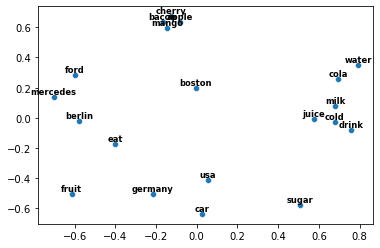

In [20]:
svd = decomposition.TruncatedSVD(n_components=2)
W1_dec = svd.fit_transform(W1)
x = W1_dec[:,0]
y = W1_dec[:,1]
plot = sns.scatterplot(x, y)

for i in range(0,W1_dec.shape[0]):
     plot.text(x[i], y[i]+2e-2, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');

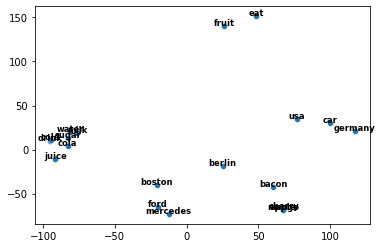

In [21]:
W2_dec = svd.fit_transform(W2)
x1 = W2_dec[:,0]
y1 = W2_dec[:,1]
plot1 = sns.scatterplot(x1, y1)
for i in range(0,W2_dec.shape[0]):
     plot1.text(x1[i], y1[i]+1, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');